# AirBnB Recruiting Challenge (Kaggle)

**Ruben Bloom**

- email: <rmb042@gmail.com>
- github: [darkruby501](https://github.com/darkruby501)

**Can we predict where a new AirBnB user will make their first booking?**

> New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.
In this recruiting competition, Airbnb challenges you to predict in which country a new user will make his or her first booking. - [AirBnB Recruiting New User Bookings Challenge on Kaggle](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)

Skewed Multiclass challenge.

## Summary

**Contents**

1. Problem Definition and the Data (Introduction)
    * Problem Definition
    * Files
    * The Measure - NDCG
    * A Note About Data Quality
3. Data Preparation: Wrangling, Cleaning, and Feature Extraction
4. Machine Learning Models
    1. Logistic Regression
        * Parameter Optimisation
    2. Random Forest
        * Confusion Matrices
        * Classification Report
        * Feature Importances
        * Validation Curve
        * Learning Curve
    3. Further Attempts
        * Imbalance / Sampling Techniques
        * One-vs-One
        * "Staged Classifiers"
5. Results and Findings
    * Untried Ideas
6. Technical Conclusion
7. Practical Recommendations
    * Evaluating recommendations

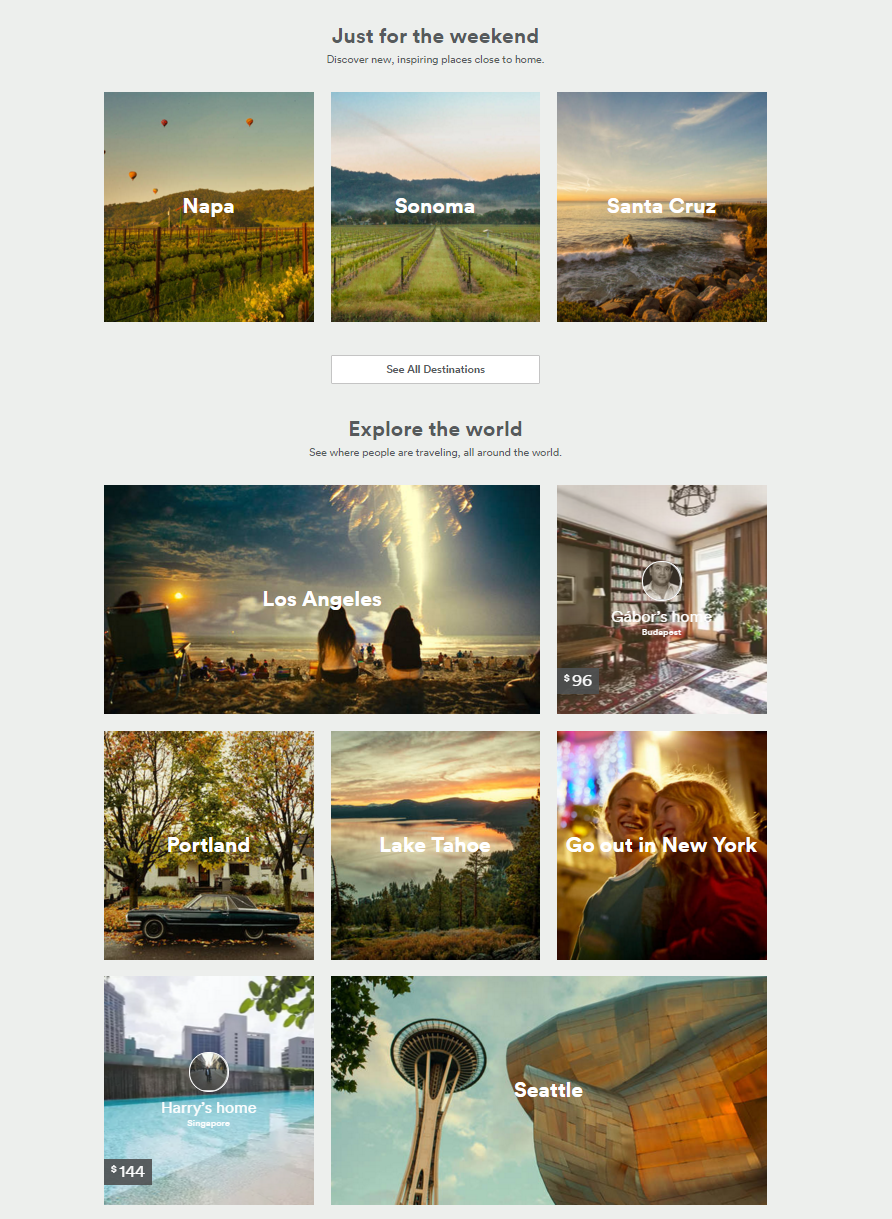

In [1]:
from IPython.core.display import Image
Image(filename='Images/airbnb_homepage_suggestions.png',width=600)

# Acknowledgements

I give thanks and credit to my Springboard mentor, Karthik Ramasay, who advised me throughout this project. And to the Kaggle community whose forum provided much useful advice, especically David Gasquez whose initial Data Exploration was especially helpful. While the project as a whole is mine, various pieces were learnt from the examples of others.

# Start your kernels!

In [2]:
from IPython.core.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("talk", font_scale=1.1)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1. Introduction

## Problem Definition
All users are from the US


**Skewed Multiclass Classificaiton Problem:**

12 classes. Below show that there is signficant skews

### Measure: Normalised Cumulative Discounted Gain

$$DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}$$

Normalised DCG is calculated by dividing the actual DCG by the maximum possible (ideal) DCG. In our case where relevance is binrary and only one result is "relevant", the maximum possible DCG is one, and so the NDCG reduces to DCG formula.


- https://www.kaggle.com/wiki/NormalizedDiscountedCumulativeGain
- https://www.kaggle.com/wendykan/airbnb-recruiting-new-user-bookings/ndcg-example
- https://gist.github.com/bwhite/3726239

In [3]:
# Create a NDCG scorer function for use with Scikit-Learn.
from rank_metrics import ndcg_at_k
from sklearn.metrics import make_scorer

def ndcg_wrapper(y_true,y_pred_proba):
    Y = np.fliplr(y_pred_proba.argsort())
      
    R = []
    NDCG = []
    for i in range(0,y_true.size):
        r = (Y[i,:]==y_true[i]).astype(int)
        R.append(r)
        NDCG.append(ndcg_at_k(r,5,method=1))
    return np.mean(NDCG)

ndcg_scorer = make_scorer(ndcg_wrapper, greater_is_better=True, needs_proba=True)

for i in range(0,5):
    print("Correct Destination in Position %d: NDGG = %.3f" % (i,ndcg_at_k([0]*i+[1],5,1)))

Correct Destination in Position 0: NDGG = 1.000
Correct Destination in Position 1: NDGG = 0.631
Correct Destination in Position 2: NDGG = 0.500
Correct Destination in Position 3: NDGG = 0.431
Correct Destination in Position 4: NDGG = 0.387


## Files Provided 
**train_users_2.csv, test_users.csv**

This is the primary database and includes user age, gender, language, time first active, date account created, sign up method, sign up flow, affiliate information, first device, first browser, and ultimate country destination of first booking.

**sessions.csv**

The sessions file contains browsing information for users at the level of individual actions. Action, action type, action detail, device type (e.g. Windows/Mac/Android/Mobile) and seconds elapsed since previous action are included. Examples rows in Table 1.

**age_gender_bkt.csv**

This file contains the number of users in each age and gender bracket, e.g. (Female, 24-29), travelling to each destination in 2015.

**countries.csv**

This file contains information on each country destination, including latitude and longitude of the country, distance from the US, size of the country, language in the country, and the Levenshtein distance  from English to the country’s language.

I did not make use of this file. Prior results that it unlikely to improve results.

## A Note About Data Quality
It should be noted that the quality of the data is unlikely to perfect. As with most user data collected online, the recording is imperfect. 

Consider that AirBnB attempts to log when a user was first active, as well as track their sessions. This is difficult because of the Many Screens Problem . A user may have been browsing extensively on one computer, perhaps at work, and then make the actual booking at home. It will appear that the user booked spontaneously without browsing. Similarly, many people browse on mobile but book at full computer. Until a user has created an account and is signed in, this is difficult to track.

Ultimately, we cannot be sure that any recorded data about a user is the complete picture of their behavioural pattern. We should expect that the data is noisy.


http://www.kaushik.net/avinash/multi-channel-attribution-definitions-models/


# 2. Data Preparation: Wrangling, Cleaning, and Feature Extraction

### Main Files: train_users.csv, test_users.csv
These are the main files for the competition and include basic information about users, including the label of which country they booked in. First let's take a little look.

In [4]:
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')
piv_train = train_users.shape[0] # Store length of train_users file
labels = train_users['country_destination'].values

all_users = pd.concat([train_users,test_users],axis=0,ignore_index=True) #Combine train and test for joint processing.
all_users_preserved = all_users

In [5]:
all_users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


Note how date_first_booking has a few NaN values, that's because people who didn't book don't have first booking dates! We will discard this column, but initially this data leak caused the restart of the AirBnB competition.

In [6]:
# Get rid of date_first_booking - not useful! 
if 'date_first_booking' in all_users.columns:
    all_users.drop(['date_first_booking'],axis=1,inplace=True)

In [7]:
print('Features in User files:\n', list(all_users.columns))
print('\n')
print("Number of Users in the Training Set = ",train_users.shape[0])
print("Number of Users in the Test Set = ",test_users.shape[0])
print('\n')
print('Earliest "Date Account Created" in Training Set:',pd.to_datetime(train_users['date_account_created']).min())
print('Latest "Date Account Created" in Training Set:',pd.to_datetime(train_users['date_account_created']).max())
print('Earliest "Date Account Created" in Test Set:',pd.to_datetime(test_users['date_account_created']).min())
print('Latest "Date Account Created" in Training Set:',pd.to_datetime(test_users['date_account_created']).max())
print('\n')
print('Destination countries: ', np.unique(train_users['country_destination']))

Features in User files:
 ['affiliate_channel', 'affiliate_provider', 'age', 'country_destination', 'date_account_created', 'first_affiliate_tracked', 'first_browser', 'first_device_type', 'gender', 'id', 'language', 'signup_app', 'signup_flow', 'signup_method', 'timestamp_first_active']


Number of Users in the Training Set =  213451
Number of Users in the Test Set =  62096


Earliest "Date Account Created" in Training Set: 2010-01-01 00:00:00
Latest "Date Account Created" in Training Set: 2014-06-30 00:00:00
Earliest "Date Account Created" in Test Set: 2014-07-01 00:00:00
Latest "Date Account Created" in Training Set: 2014-09-30 00:00:00


Destination countries:  ['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']


Training Set contains users from the period January 2010 - June 2014. Test Set contains users from July - September 2014.

#### Comments
Destination Countries: Australia, Canada, Germany, Spain, France, Great Britain, Italy, "No Destination Found", Netherlands, Portugal, USA, "other".

No Destination Found means no booking was made for that user within the measured period. "Other" means a booking was made to a country not already listed.

#### Imbalanced Classes - Number of Bookings in Each Country
Very imbalanced. The bulk do not book.

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


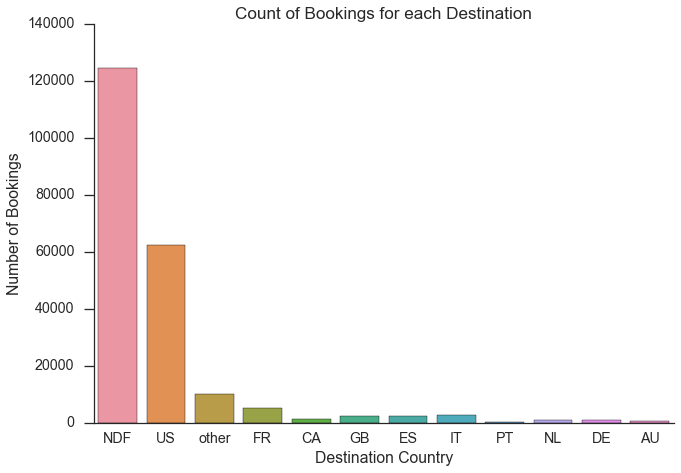

In [8]:
sns.countplot(x="country_destination",data=train_users)
plt.xlabel('Destination Country')
plt.ylabel('Number of Bookings')
plt.title('Count of Bookings for each Destination')
sns.despine()

### Missing Values

In [9]:
# Replace "-unknown-" gender values with NaN
all_users['gender'].replace('-unknown-',np.nan, inplace=True)

# How many values are missing?
all_nan = (all_users.isnull().sum() / all_users.shape[0]) * 100
print('Missing Data Percentages for Each Feature:\n', all_nan[all_nan > 0],sep='')
print('\n')

# How many first_affiliate_tracked values are "untracked"?
print('% of "first_affiliates" with value "untracked"):',sum(all_users['first_affiliate_tracked']=='untracked')/len(all_users))
# Set missing values to 'untracked'
all_users['first_affiliate_tracked'].fillna('untracked',inplace=True)


Missing Data Percentages for Each Feature:
age                        42.412365
country_destination        22.535538
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64


% of "first_affiliates" with value "untracked"): 0.519624601248


42% of ages values and 47% of gender values are missing and must be dealt with. 

*first_affiliate_tracked* is missing only a few percent of valeus, but inspection shows that in fact 50% of the first_affiliate_tracked values are "untracked". We might as well fill the NaNs with "untracked" as well.

#### Missing and Invalid Age Values

In [10]:
print('User Age Summary Stats:\n',all_users['age'].describe(),sep='')
print('\n')
print('Number of user age values > 100:', sum(all_users.age > 100))
print('Number of user age values < 15:', sum(all_users.age < 15))

#Consider ages outside of range [15,100) as invalid and set to missing.
all_users.loc[all_users['age'] > 100, 'age'] = np.nan
all_users.loc[all_users['age'] < 15, 'age'] = np.nan

#Replace missing age values with -1 to create distinct cluster.
all_users['age'].fillna(-111,inplace=True) #replace missing values with out of range value.


User Age Summary Stats:
count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64


Number of user age values > 100: 2690
Number of user age values < 15: 59


Age is missing a lot of values, so it needs a closer look. Examination shows that the minimum age is 1 (much too young!) and the oldest age is 2014 (quite a record!). There are 2749 invalid entries which I will lump together with the missing values by setting them to NaN.

#### Imputation: Missing at random? Or not?
Although it is common to blithely replace missing values with mean, median or randomly, we cannot do so before asking about the nature of the missing values. How did they come to be missing?

In our case, age and gender values are missing because users didn't fill them in or didn't fill them in correctly\*. As we might expect users with more serious intentions to fill out forms correctly, it is important information to know whether a user did or did not. Crucially there may be difference in behaviour between the cluster of female 20-24 year olds who did fill out the forms and those who didn't. We don't want to prematurely collapse that distinction. 

For this reason, I chose to set missing ages to -1 so that the trained classifier might treat them as their own category. As a Logistic Regression classifier cannot handle non-linear features in this manner, I later impute the median before training it.

See *Data Analysis Using Regression and Multilevel/Heirarchical Models, [Ch. 25](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)*, by Gelman and Hill for a great intro to handling missing values.

\* All users created accounts, so it's not just a matter of people never creating an accounts. Although it now seems you can't sign up to AirBnB with providing age. You can join using your Facebook or Gmail accounts, possibly without providing age.

### More Processing 
#### One-Encoding, Discretisation, Segmenting Date Values

In [11]:
## One-Hot Encoding
categorical_features = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
                      'first_browser','first_device_type','gender','language','signup_app','signup_flow','signup_method']
all_users = pd.get_dummies(all_users,columns=categorical_features)

# Discretise Age
A = pd.cut(all_users['age'],list(range(14,100,5)),right=True)
A = pd.get_dummies(A)
all_users = pd.concat([all_users,A],axis=1)

# Segment date components
# date_account_created
dac = np.vstack(all_users.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
all_users['dac_year'] = dac[:,0]
all_users['dac_month'] = dac[:,1]
all_users['dac_day'] = dac[:,2]
all_users.drop(['date_account_created'],axis=1,inplace=True)

#time first active
tfa = np.vstack(all_users.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
all_users['tfa_year'] = tfa[:,0]
all_users['tfa_month'] = tfa[:,1]
all_users['tfa_day'] = tfa[:,2]
all_users['tfa_hour'] = tfa[:,3]
all_users.drop(['timestamp_first_active'],axis=1,inplace=True)

#### One-Hot Encoding of Categorical Features
To the make data suitable for a classifier, categorical variables (including gender) were converted to one-hot encoding. E.g. the gender feature become three mutually exclusive, binary features: gender_FEMALE, gender_MALE, and gender_OTHER. If a user entered 'female', gender_FEMALE will correspondingly be high.

*The creation of dummy values provides a solution to the missing gender values.* Instead of needing to impute missing values, after one-hot encoding, users with no gender entered will have 0 in all gender features. It was also possible to create a gender_NaN column, althouh I have not tested if this improves accuracy. 

#### Discretisation of Age
To further aid the machine learning models with non-linear data, the age feature was also transformed into discrete age brackets, e.g [20-24], similar to the one-hot encoding. The original numerical age feature was retained.

#### Segmentation of Dates
To allow the classifiers to more easily pick up patterns in the data at different time scales, date and time values were split into YEAR/MONTH/DAY/HOUR rather than a single numerical value. 

## Session Files: sessions.csv

List of actions for each user.

Users only for 2014 onwards. All test users. 


In [12]:
session_df = pd.read_csv('input/sessions.csv')
session_users = session_df

# Clean missing values
session_users['secs_elapsed'].fillna(0,inplace=True)
session_users['action_type'].fillna('',inplace=True)

session_df.head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,,NaN,Windows Desktop,435
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703
6,d1mm9tcy42,lookup,,NaN,Windows Desktop,115
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842
9,d1mm9tcy42,lookup,,NaN,Windows Desktop,683


Need process this into features! Count up different actions types for each user (Combining Action-Action Detail since action_type seems relatively boring.

#### Missing Values in Session Features
There are some missing values, but these are not a problem. Some website actions just don't take any time, so we can set them as zero. Some actions don't have a "type".

### Creating Session Features
#### Action counts, Total time spent on each device type, Number of devices types used

In [13]:
## Okay let's try adding all the groupings separately.
session_action = session_users.groupby(['user_id','action']).count()['secs_elapsed'].unstack().fillna(0)
session_action_type = session_users.groupby(['user_id','action_type']).count()['secs_elapsed'].unstack().fillna(0)
session_action_detail = session_actions = session_users.groupby(['user_id','action_detail']).count()['secs_elapsed'].unstack().fillna(0)

sessions_pure = pd.merge(session_action,session_action_type,left_index=True,right_index=True,how='inner')
sessions_pure = sessions_pure.merge(session_action_detail,left_index=True,right_index=True,how='inner')

In [14]:
## WHAT HAPPENS IF WE NORMALISE THESE?
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()

sp_cols = sessions_pure.columns
sp_index = sessions_pure.index
sessions_pure = scaler.fit_transform(sessions_pure)
sessions_pure = pd.DataFrame(sessions_pure,columns=sp_cols,index=sp_index)

In [15]:
# Create New Combined Feature for Grouping
session_users['action_action_detail'] = session_users['action']+'__'+session_users['action_detail']
session_users2 = session_users.groupby(['user_id','action_action_detail']).count()['secs_elapsed'].unstack().fillna(0)
print('Number of Action Count Features created:', session_users2.shape[1])
print('\n')

Number of Action Count Features created: 436




In [16]:
sessions = session_users2

#### Action Counts 
How many times a user performed a certain action. Action Type was boring. Just combined action,action_detail for grouping.

#### Time Spent on Each Device, Number of Device Types Used

Separately, we can extract the number of different device types usesd by a user to access AirBnB.

In [17]:
# Time spent on each Device
deviceusage_df = session_df[session_df['secs_elapsed']<60*100][['user_id','device_type','secs_elapsed']].groupby(['user_id','device_type']).sum().unstack()['secs_elapsed']
# Number of device types used
deviceusage_df['num_devices'] = session_df.groupby('user_id')['device_type'].agg(lambda x: len(np.unique(x.values)))
deviceusage_df.fillna(0,inplace=True)
deviceusage_df.head(2)

device_type,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,num_devices
user_id,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,25452,0,0,0,0,0,5089,0,2
0010k6l0om,0,0,0,0,0,0,36884,0,0,0,0,0,0,0,1


#### Features Related to Session Length
Examining the session records, it's clear that the "secs_elapsed" (since previous action) variable is extremely large for actions. I assume that these large values mark the periods between different occasions that a user was continuious engaging with the AirBnB website, e.g. spent 20 minutes browsing Tuesday morning, and then another 40 minute on Thursday evening. 

With appropriate processing, a number of new features can be extracted from the session logs, including: number of sessions, length spent website, maximum and average times between sessions, average seconds per action, and few others.

In [18]:
## Features about individual sessions (sittings)
in_session_actions = session_df[session_df['secs_elapsed']<100*60].groupby('user_id')
AA = in_session_actions['secs_elapsed'].agg({'total_session_times': np.sum,
                                        'mean_secs_per_action' : np.mean,
                                            'num_actions_insession' : np.size})

## Features related to the number of sessions 
between_session_actions = session_df[session_df['secs_elapsed']>200*60].groupby('user_id')
BB = between_session_actions['secs_elapsed'].agg({'num_sessions': np.size,
                                            'mean_between_sessions' : np.mean,
                                            'max_between_sessions': np.max
                                            })

session_times = pd.merge(AA,BB,how='outer',left_index=True,right_index=True)

#Count number of different days spent on AirBnB. Obtained by looking for number of breaks longer than 18 hours.
session_times['num_days'] = session_df[session_df['secs_elapsed']>18*3600].groupby('user_id').count()['secs_elapsed']
session_times.fillna(0,inplace=True)
session_times['num_sessions'] += 1 # Doesn't really make a difference
session_times['num_days'] += 1 
session_times['all_time'] = session_df.groupby('user_id').sum()['secs_elapsed']

session_times.head(3)

,mean_secs_per_action,total_session_times,num_actions_insession,num_sessions,max_between_sessions,mean_between_sessions,num_days,all_time
user_id,,,,,,,,
00023iyk9l,954.406250,30541,32,8,567165,118202.428571,3,867896
0010k6l0om,768.416667,36884,48,12,127898,46397.636364,4,586543
001wyh0pz8,1240.833333,96785,78,7,50548,22506.333333,1,282965


### Session Feature Selection
Generated A LOT of features. Slow down training. Feature selection using SelectKBest. F-ANOVA to each variable. Sample sizes vary significantly, so the ANOVA might be a little messy ... but whatever.

Feature selection using two main classes.

c:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  5   7  10  12  15  16  63  65  80  82  83  84  85  89  90  92 114 124
 127 131 135 136 141 154 171 179 188 196 197 198 199 200 201 203 239 258
 259 319 324 332 334 335 339 343 348 349 360 362 378 383 386 390 393 411
 427] are constant.
  UserWarning)
c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


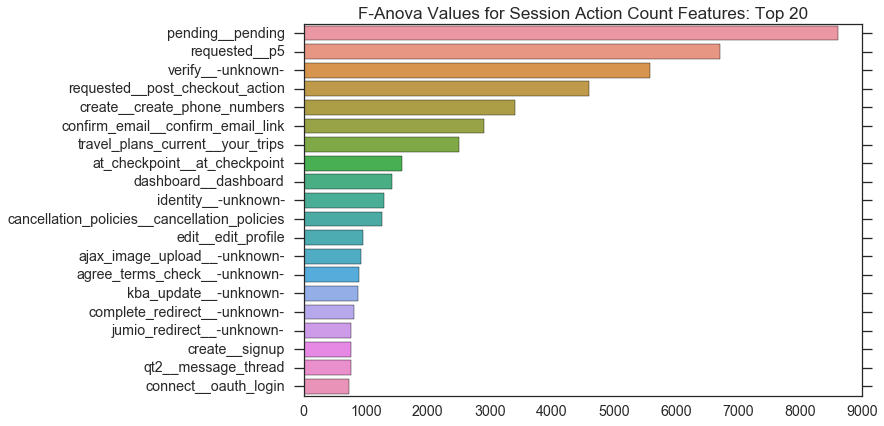

In [19]:
## Need to attach labels for feature selection.
SessionX = pd.merge(train_users[['id','country_destination']],sessions,right_index=True,left_on='id',how='inner')
Sessiony = SessionX['country_destination']!="NDF" # Turn this into a binary classification problem
SessionX.drop(['id','country_destination'],axis=1,inplace=True)


# Perform selection
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=100)
selector.fit(SessionX,Sessiony)
sessions = sessions[sessions.columns[selector.get_support()]]

# Examine feature selection univariate statistics test results:
FeaturePvalues = pd.Series(index=SessionX.columns,data=selector.pvalues_).sort_values(ascending=True)
FeatureScores = pd.Series(index=SessionX.columns,data=selector.scores_).sort_values(ascending=False)
# Plot
k = 20
plt.figure(figsize=(10,k/3))
sns.barplot(y=FeatureScores.index[0:k],x=FeatureScores.head(k))
plt.title('F-Anova Values for Session Action Count Features: Top 20')

In [20]:
## Features about *when* users were active

A = session_df.groupby('user_id').cumsum()
A['user_id'] = session_df['user_id']

# Vectorised/Dataframe Calculation of when users where active
b = A['secs_elapsed'].values
A['Diff'] = -(b-(np.append(b[1:],0)))
A['Diff'] = np.insert(A['Diff'].values[:-1],0,0) # Need to shift values to keep 1-st order diff aligned
# and users separate.
A.loc[A['Diff']>100*60,'Diff']=0
A.loc[A['Diff']<1,'Diff']=0


A['Week'] = A['secs_elapsed']//(86400*7)
A['CumDiff'] = A.groupby(['user_id','Week']).cumsum()['Diff']/3600
WeekFeatures = A.groupby(['user_id','Week']).sum()['Diff']
num_weeks = 6
WeekFeatures = WeekFeatures.unstack()[np.arange(0,num_weeks)].fillna(0)//3600
# Output is feature vector for each user with number hours spent on site for each of the first num_weeks.
# Approximate as timestamps not given.

In [21]:
# Convert to percentage of total activity time each week.
WeekFeatures = WeekFeatures.divide(WeekFeatures.sum(axis=1),axis=0).round(3).fillna(0)

In [22]:
WeekFeatures

,0.0,1.0,2.0,3.0,4.0,5.0
user_id,,,,,,
00023iyk9l,0.429,0.571,0.000,0.000,0.000,0.000
0010k6l0om,1.000,0.000,0.000,0.000,0.000,0.000
001wyh0pz8,1.000,0.000,0.000,0.000,0.000,0.000
0028jgx1x1,1.000,0.000,0.000,0.000,0.000,0.000
002qnbzfs5,0.241,0.306,0.139,0.315,0.000,0.000
0031awlkjq,1.000,0.000,0.000,0.000,0.000,0.000
0035hobuyj,0.304,0.043,0.000,0.152,0.065,0.435
00378ocvlh,0.444,0.333,0.167,0.056,0.000,0.000
00389675gq,0.242,0.000,0.242,0.364,0.152,0.000


#### Join all Session Features Together

In [23]:
## Join all session features together
SessionFeatures = pd.merge(sessions,deviceusage_df,right_index=True,left_index=True,how='inner')
SessionFeatures = pd.merge(SessionFeatures,session_times,right_index=True,left_index=True,how='inner')
SessionFeatures = pd.merge(SessionFeatures,WeekFeatures,right_index=True,left_index=True,how='inner')
print('Total number of Session Features created:', SessionFeatures.shape[1])

Total number of Session Features created: 129


### Demographic Bracket Features: age_gender_brackets.csv
This file contains the number of users in each age and gender bracket, e.g. (Female, 24-29), travelling to each destination in 2015.

In [24]:
age_gender_df = pd.read_csv('input/age_gender_bkts.csv')
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015


#### Convert to Normalised Pivot Table 
For each and age-gender bracket, divide the number of individuals users in each destination by the total number of users in the age bracket. Get the percentage of users from that group travelling to each destination.

The appropriate row can be appended to each user as a kind of more 'objective prior' (in the Bayesian sense) from outside the dataset.

If age or gender are missing, append the overall prior.

In [25]:
# Convert to normalised Pivot Table
A = pd.pivot_table(age_gender_df,values='population_in_thousands',index=['age_bucket','gender'],columns='country_destination')
normalised_brackets = A.divide(A.sum(axis=1),axis=0)
normalised_totals = A.sum()/A.sum().sum() ## Hmm, really this shouldn't assume a uniform prior over brackets when missing.
normalised_brackets.head()

country_destination        AU        CA        DE        ES        FR  \
age_bucket gender                                                       
0-4        female    0.037438  0.047505  0.082115  0.057428  0.092901   
           male      0.037583  0.047662  0.082600  0.058016  0.092816   
10-14      female    0.034254  0.045010  0.087209  0.054457  0.091764   
           male      0.034392  0.045501  0.087576  0.055036  0.091881   
100+       female    0.027586  0.048276  0.096552  0.062069  0.131034   

country_destination        GB        IT        NL        PT        US  
age_bucket gender                                                      
0-4        female    0.090504  0.066296  0.020996  0.010786  0.494032  
           male      0.090353  0.066956  0.021072  0.010901  0.492041  
10-14      female    0.081880  0.067248  0.023886  0.013033  0.501260  
           male      0.081976  0.067950  0.023931  0.013192  0.498565  
100+       female    0.089655  0.103448  0.013793  0.006897  0.420690

#### Create and Append Features

In [26]:
# Fuctions for Apply
def age_bucket_converter(age, gender):
    #Create tuple of (Age,Gender) pair, output needs to match indices of Pivot Table
    if (age>0)&(age<100):
        a = int((age//5)*5)
        Age = str(a)+'-'+str(a+4)
        if Age == '5-9': Age = 'Missing'
    elif age>99: Age = '100+'
    else: Age = 'Missing'
        
    if gender == 'MALE': Gender = 'male'
    elif gender == 'FEMALE': Gender = 'female'
    else: Gender = 'Missing'
    return (Age, Gender)

def bkts_feature_create(age_gender,normalised_brackets,normalised_totals):
    # Return appropriate row of pivot table for (age,gender) bracket 
    Age,Gender = age_bucket_converter(*age_gender)
    #print([Age,Gender])
    
    if ((Age=='Missing')|(Gender=='Missing')):
        return normalised_totals
    else:
        return normalised_brackets.loc[(Age,Gender)]
    
# Create Features    
BracketFeatures = all_users_preserved[['age','gender']].apply(lambda x: bkts_feature_create(tuple(x.values),normalised_brackets,normalised_totals),axis=1)
BracketFeatures.set_index(all_users['id'],inplace=True)

## Combine All Features!!
For use in training the models

In [27]:
# Merge with Session Features
All = all_users.merge(SessionFeatures,how='inner',left_on='id',right_index=True)

# Merge with Bracket Features
All = All.merge(BracketFeatures,how='inner',left_on='id',right_index=True) 

print('num users total = ',All.shape[0])
print('num features = ',All.shape[1])

num users total =  135038
num features =  318


#### Loss of rows without session features
Since the Session Features is only for users since 2014, by combining the basic features with the Session Features using a simple inner join, I am dramatically reducing the training set from 213,451 to 70,xxx - a dramatic drop! This is probably okay. Subsequent resuts (learning curves) suggest that models created will not benefit from the additional examples.

Information might be lost is that the training samples are only from the first six months of 2014, whereas test users are for the third quarter. Using only those training samples loses seasonal variation. That would be a reason to want to include information from earlier samples too.

One way to make use of all the samples might be to ensemble two classifiers: one trained using all the samples but without session features, and the other trained on the subset with features. I have not yet tried this, but am somewhat pessimistic.

# 3. Machine Learning Models

### Imports

In [28]:
#Imports
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing

### Sample Subset Selecion
Given the large number of classes and severe imbalance, it seemed worthwhile to initially limit the problem to classifying only the five largest classes. Collectively, these classes still account for 96.5% of all training samples.

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#included_destinations = ['NDF','US'] # Binary among majority classes.
included_destinations = ['NDF','US','FR','IT','other'] #,'GB','ES']
# included_destinations = ['FR','IT','GB','ES'] #Largest minority classe

X  = All[All['country_destination'].isin(included_destinations)]
y = le.fit_transform(X['country_destination'])
X = X.drop(['country_destination','id'],axis=1)

X_Test = All[All['country_destination'].isnull()].drop(['country_destination','id'],axis=1)
X_Test_ids = All[All['country_destination'].isnull()]['id']

print('Num Training Samples:', X.shape[0])
print('Num Features:',X.shape[1])
#print(list(zip(le.classes_,range(0,len(y)))))

Num Training Samples: 70799
Num Features: 316


In [30]:
print(list(zip(le.classes_,range(0,len(y)))))

[('FR', 0), ('IT', 1), ('NDF', 2), ('US', 3), ('other', 4)]


### Dummy Estimator
To get a sense of how well our classifiers are performing, it helps to compare with a dummy classifier which uses a simple heuristic, i.e. all the dominant class, or based on class priors. Since we need to generate the five most likely destinations in order of likelihood, let's use a dummy classifiers which suggests them based on class frequency (class prior).

In [31]:
# Compare with basic. If you can't beat this, there's a probelm.
from sklearn.dummy import DummyClassifier
Dummy = DummyClassifier(strategy='prior').fit(X,y)
dummy_score = ndcg_scorer(Dummy,X,y)
print('NDCG score for Dummy Estimator: {0:.4f}'.format(dummy_score))

NDCG score for Dummy Estimator: 0.8503


## Logistic Regression
Why? Simple. Establish baseline. Interpretable.

One-vs-Rest (although multinomial exists)

#### Logistic Regression Preprocessing

In [37]:
Xsave = X #save original values for later use in Random Forest.

# Impute missing values to median to maintain linearity
X['age'].replace(-1,np.median(X['age']),inplace=True)
# Scale, helps with convergence
scaler = preprocessing.MinMaxScaler()
X['age'] = scaler.fit_transform(X['age'])

c:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [38]:
X

,age,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,...,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
137021,0.819905,0,0,0,0,0,0,1,0,0,...,0.030400,0.052292,0.123082,0.059032,0.090388,0.080923,0.083600,0.024999,0.014722,0.440562
137022,0.000000,0,0,1,0,0,0,0,0,0,...,0.032677,0.048996,0.112772,0.064475,0.088761,0.087199,0.083518,0.023013,0.014491,0.444099
137023,0.000000,0,0,0,0,0,1,0,0,0,...,0.032677,0.048996,0.112772,0.064475,0.088761,0.087199,0.083518,0.023013,0.014491,0.444099
137024,0.000000,0,0,1,0,0,0,0,0,0,...,0.032677,0.048996,0.112772,0.064475,0.088761,0.087199,0.083518,0.023013,0.014491,0.444099
137026,0.000000,0,0,1,0,0,0,0,0,0,...,0.032677,0.048996,0.112772,0.064475,0.088761,0.087199,0.083518,0.023013,0.014491,0.444099
137027,0.677725,0,0,0,0,0,0,0,1,0,...,0.036052,0.051682,0.107156,0.068603,0.085275,0.088026,0.074647,0.020714,0.015088,0.452757
137028,0.000000,0,0,1,0,0,0,0,0,0,...,0.032677,0.048996,0.112772,0.064475,0.088761,0.087199,0.083518,0.023013,0.014491,0.444099
137029,0.616114,0,0,0,0,0,1,0,0,0,...,0.032677,0.048996,0.112772,0.064475,0.088761,0.087199,0.083518,0.023013,0.014491,0.444099
137031,0.644550,0,0,1,0,0,0,0,0,0,...,0.036851,0.052415,0.106765,0.055462,0.085684,0.091119,0.068885,0.021328,0.012723,0.468769
137032,0.677725,0,0,1,0,0,0,0,0,0,...,0.036052,0.051682,0.107156,0.068603,0.085275,0.088026,0.074647,0.020714,0.015088,0.452757


In [39]:
from sklearn.linear_model import LogisticRegressionCV
LR = LogisticRegressionCV(class_weight='balanced',scoring=ndcg_scorer) #class_weight='balanced'
LR.fit(X,y)

ZeroDivisionError: float division by zero

In [ ]:
y_pred = clf.predict(X_train)
print('NDCG = ',ndcg_scorer(clf,X_train,y_train))
print('Accuracy = ',metrics.accuracy_score(y_train,y_pred))
print('Recall = ',metrics.recall_score(y_train,y_pred))
print('Precision = ',metrics.precision_score(y_train,y_pred))

In [ ]:
print('NDCG = ',ndcg_scorer(LR,X,y))

In [40]:
#%%timeit -r1
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C = 0.0005,class_weight='balanced')

#Need to stratify.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('NDCG = ',ndcg_scorer(clf,X_test,y_test))
print('Accuracy = ',metrics.accuracy_score(y_test,y_pred))


NDCG =  0.828345261382
Accuracy =  0.601807909605


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 0.001,class_weight='balanced',multi_class='multinomial',solver='lbfgs')
score = cross_val_score(clf,X,y,cv=5,scoring=ndcg_scorer)
print(np.mean(score))
score

In [ ]:
y_pred = LR.predict(X)
print('NDCG = ',ndcg_scorer(LR,X,y))
print('Accuracy = ',metrics.accuracy_score(y_train,y_pred))
print('Recall = ',metrics.recall_score(y_train,y_pred))
print('Precision = ',metrics.precision_score(y_train,y_pred))

In [ ]:
LR.predict(X)

In [ ]:
LR.Cs_

In [ ]:
np.sqrt(516)

## Random Forest
Because . . . inherently multiclass . . . non-linearities

In [32]:
from sklearn.ensemble import RandomForestClassifier
#X = Xsave

In [33]:
RF = RandomForestClassifier(n_estimators=100,max_features=30,n_jobs=-1) #,class_weight='balanced')
RF.fit(X,y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=30, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
RF = RandomForestClassifier(n_estimators=200,n_jobs=-1,class_weight='balanced',oob_score=True)
CV_score = cross_val_score(RF,X,y,scoring=ndcg_scorer, cv=5, verbose=2)
print('CV scores = ',CV_score)
print('Mean CV score = ', np.mean(CV_score))

#### Parameter Search

In [ ]:
mf_range = [25,40]
grid = GridSearchCV(RandomForestClassifier(n_estimators=100),
                    param_grid={'max_features': mf_range},scoring=ndcg_scorer,cv=5)
grid.fit(X,y)

#### Classificatior Report and Confusion Matrix

In [58]:
#Requires predictions from train test split.
RF = RandomForestClassifier(n_estimators=200,max_features=30,n_jobs=-1,class_weight='balanced',oob_score=True) #,class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)



In [66]:
le.classes_

array(['FR', 'IT', 'NDF', 'US', 'other'], dtype=object)

In [68]:
RF.oob_decision_function_

array([[ 0.01,  0.01,  0.3 ,  0.58,  0.1 ],
       [ 0.03,  0.  ,  0.72,  0.23,  0.01],
       [ 0.04,  0.01,  0.32,  0.61,  0.01],
       ..., 
       [ 0.02,  0.  ,  0.34,  0.63,  0.01],
       [ 0.  ,  0.02,  0.86,  0.11,  0.02],
       [ 0.  ,  0.03,  0.3 ,  0.52,  0.14]])

In [69]:
ndcg_wrapper(y_test,RF.oob_decision_function_)

0.81414412226403254

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test)

#dummy_score = ndcg_scorer(Dummy,X_test,y_test)
ndcg_score = ndcg_scorer(RF,X_test,y_test)
print('ndcg = ', ndcg_score)
print('dummy = ', dummy_score)
print('improvement over dummy: %3.3f%%' % ((ndcg_score - dummy_score)*100))

ndcg =  0.884594485001
dummy =  0.850313791469
improvement over dummy: 3.428%


In [95]:
list(le.classes_)

['FR', 'IT', 'NDF', 'US', 'other']

In [45]:
## Classificaiton Report
clf = RF
y_pred = clf.predict(X_test) 
print(metrics.classification_report(y_test,y_pred,target_names=le.classes_))


             precision    recall  f1-score   support

         FR       0.00      0.00      0.00       279
         IT       0.00      0.00      0.00       194
        NDF       0.77      0.89      0.83      8954
         US       0.60      0.57      0.58      4017
      other       0.50      0.00      0.00       716

avg / total       0.68      0.72      0.69     14160



c:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
1762/4017

In [46]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion matrix
[[   0    0  143  136    0]
 [   0    0   95   99    0]
 [   0    0 7965  989    0]
 [   0    0 1720 2296    1]
 [   0    0  381  334    1]]


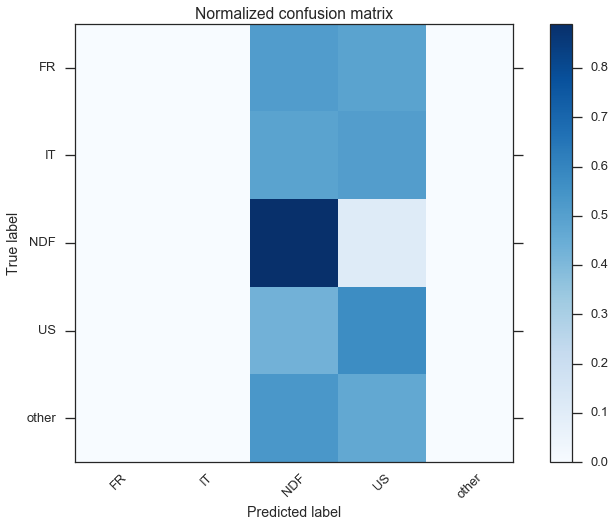

In [48]:
sns.set_context("talk")
#cm = confusion_matrix(y, clf.predict(X))
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion matrix')
print(cm)
classes=le.classes_
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

#### Feature Importances

http://stats.stackexchange.com/a/92843/97964

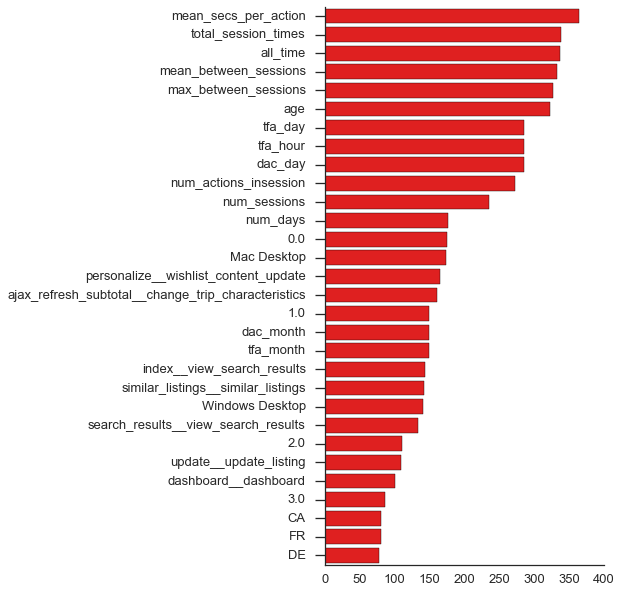

In [54]:
#RF.fit(X,y)
FeatureImportances = pd.Series(index=X.columns,data=RF.feature_importances_).sort_values(ascending=False)
FeatureImportances = (FeatureImportances*10000).round()
k = 30
plt.figure(figsize=(5,10))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k),color='red')
sns.despine()

In [ ]:
(pd.Series(index=X.columns,data=RF.feature_importances_)*10000).round()

In [35]:
from sklearn.cross_validation import StratifiedKFold

In [36]:
from sklearn.learning_curve import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(RF, X, y,scoring='accuracy',
                                                         train_sizes=[0.5,0.8,0.9,1],cv=StratifiedKFold(y,shuffle=True))


Plotting Learning Curves

On the left side the learning curve of a naive Bayes classifier is shown for
the digits dataset. Note that the training score and the cross-validation score
are both not very good at the end. However, the shape of the curve can be found
in more complex datasets very often: the training score is very high at the
beginning and decreases and the cross-validation score is very low at the
beginning and increases. On the right side we see the learning curve of an SVM
with RBF kernel. We can see clearly that the training score is still around
the maximum and the validation score could be increased with more training
samples.



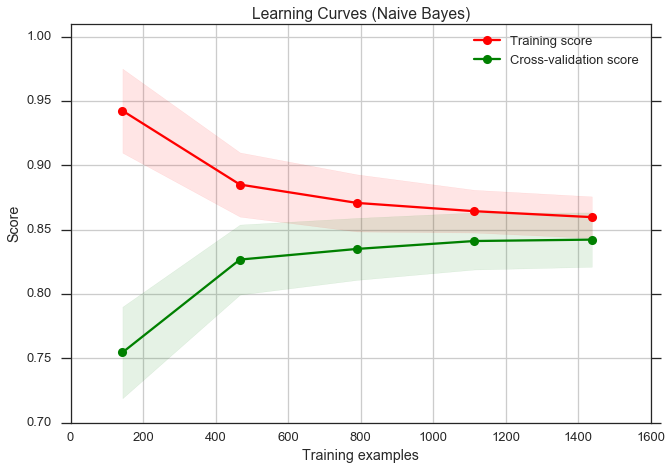

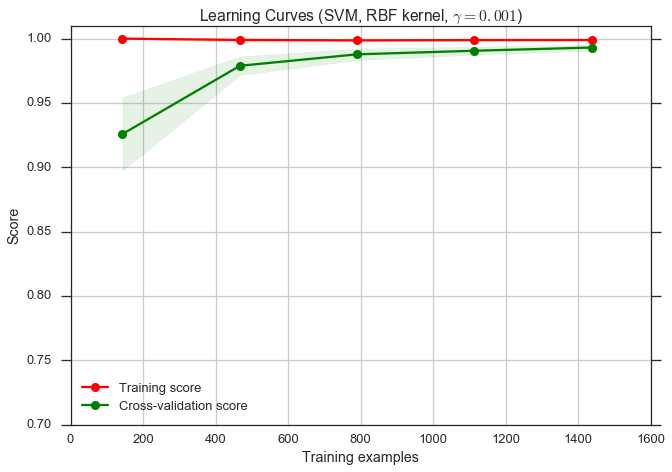

In [55]:
from plot_learning_curve import plot_learning_curve

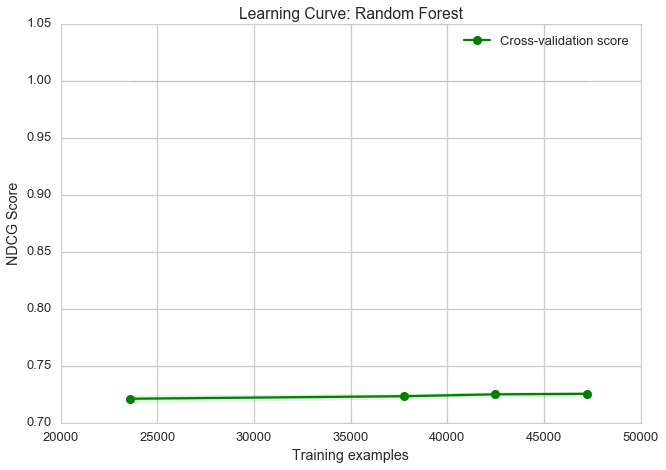

In [38]:
sns.set_style("whitegrid") #, {'ytick.major.size': 10.0})
sns.set_context("talk")

plt.figure()
#plt.title(title)
#if plt.ylim is not None: plt.ylim([0.8,0.9])
#plt.xlabel = 'H'
plt.xlabel("Training examples")
plt.ylabel("NDCG Score")

#train_sizes, train_scores, test_scores = learning_curve(    estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
#plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.grid()
plt.title('Learning Curve: Random Forest')

plt.grid()

In [84]:
valid_scores[4,2]

0.8785178763211936

In [57]:
RF.oob_score

False

In [40]:
for i in range(0,4):
    print('{0:5f}'.format(test_scores_mean[i]))

0.721027
0.723231
0.724897
0.725335


In [64]:
from sklearn.learning_curve import validation_curve

train_scores, valid_scores = validation_curve(RandomForestClassifier(n_jobs=-1,class_weight='balanced')
                                              , X, y, "max_features", [80,100],cv=StratifiedKFold(y,n_folds=5,shuffle=True),
                                              scoring= ndcg_scorer)

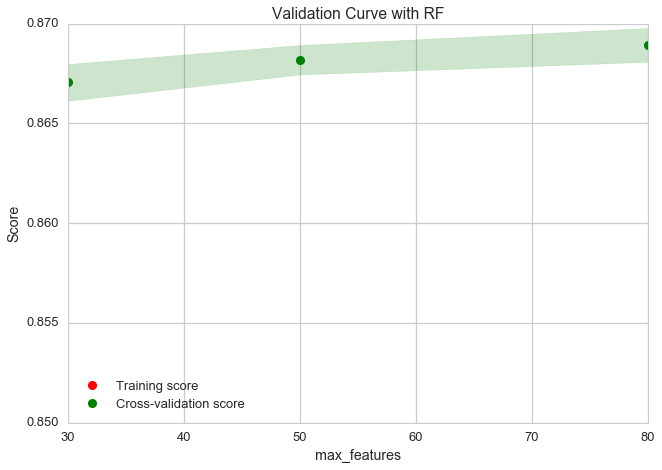

In [54]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

param_range = [30,50,80]

plt.title("Validation Curve with RF")
plt.xlabel("max_features")
plt.ylabel("Score")
plt.ylim(0.85, 0.87)
plt.plot(param_range, train_scores_mean,'ro', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean,'go', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [68]:
for i in range(0,3):
    print('{0:.3f}'.format(test_scores_mean[i]))

0.867
0.868
0.869


In [72]:
test_scores_mean = np.mean(valid_scores, axis=1)
for i in range(0,3):
    print('{0:.4f}'.format(test_scores_mean[i]))

0.8691
0.8685


IndexError: index 2 is out of bounds for axis 0 with size 2

In [70]:
np.mean(valid_scores,axis=1)

array([ 0.86913405,  0.86854621])

## XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0,
                   )  

In [ ]:
CV_score = cross_val_score(xgb,X.values,y,scoring=ndcg_scorer, cv=5, verbose=1)


In [ ]:
print('CV scores = ',CV_score)
print('Mean CV score = ', np.mean(CV_score))

In [ ]:
xgb.fit(X.values,y)

In [ ]:
RF

# Test Submissions

In [ ]:
def create_sub(preds,id_test):
##Format predictions for Kaggle online submission
    
    n = 5

    ids = [] # list of id's
    cts = [] # list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx]*n
        cts += list(preds[i][0:n])
    
    submission = pd.DataFrame(np.column_stack((ids,cts)), columns=['id','country'])
    return submission



In [ ]:
test_users_proba = RF.predict_proba(X_Test) #xgb.predict_proba(X_Test.values)
test_users_preds = le.inverse_transform(np.fliplr(test_users_proba.argsort()))
print(test_users_preds[3][0:5])

submission = create_sub(test_users_preds,X_Test_ids.values)
submission.to_csv('output/sub_rf_5class_pure_weeks_400_n8_516p_unbalanced.csv',index=False)